# Universal Path Decomposition of Multilayer Transfer and Scattering Matrices


## Quantum Mechanics Example

**Companion** to the homonymous paper by *Joaquin Garcia-Suarez* (2025)


This notebook provides an interactive implementation of the concepts introduced in the paper. The parameters are chosen to generate the results in Figure ??? of the main text. All computations are based on constant-mass assumption, units are normalized.


---

### Constants

- **ħ (hbar)** is set to 1.0, using natural units to simplify calculations.
- **m** is the effective mass of the particle (e.g., electron), also normalized to 1.0.

---

### Potential Profile

- **V** is an array of potential energies (in electronvolts) for three spatial regions (or layers). These values define a stepwise potential landscape that the particle will encounter.
- **l** is the array of widths (in nanometers) for each corresponding potential region. All three layers have the same width.
- **N** represents the number of layers, derived from the length of the potential array.

This defines a 1D system often used to study quantum tunneling, barrier penetration, and similar phenomena.

---

### Energy Range

- **E_list** is an array containing 1000 energy values linearly spaced from 0.01 eV to 5.0 eV.

This range is used to simulate different possible energies of incident electrons, which will be tested against the potential profile to determine their transmission and reflection probabilities.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations


# Constants (units: eV, nm, normalized ħ = 1)
hbar = 1.0
m = 1.0  # effective mass (scaled)

# Potential profile
V = np.array([1.0, 10.0, 20.0])    # potential in each layer
l = np.array([1.0, 1.0, 1.0])    # width of each layer

N = len(V)

# Energy range for electrons (eV)
E_list = np.linspace(0.01, 5.0, 1000)


# Transfer Matrices

### Transfer Matrix Method (TMM) for a Single Quantum Layer

This function defines the **transfer matrix** for a single layer of constant potential in a one-dimensional quantum system. The transfer matrix relates the wavefunction and its derivative across the layer forpropagation through layered media.

---

### Function: `quantum_layer_T(k, l)`

- **Parameters**:
  - `k`: The wave number in the region, related to the particle's energy and potential.
  - `l`: The width of the layer.

- **Returns**:
  - A 2×2 NumPy array representing the transfer matrix for a single layer.

---

### Mathematical Background

The transfer matrix \( T \) for a region with constant potential is derived from the general solution of the time-independent Schrödinger equation. For a region of width \( l \) and wave number \( k \), the matrix is:

$$
T =
\begin{bmatrix}
\cos(kl) & \frac{\sin(kl)}{k} \\
- k \sin(kl) & \cos(kl)
\end{bmatrix}
$$

This matrix maps the wavefunction and its derivative from one side of the layer to the other:

$$
\begin{bmatrix}
\psi(l) \\
\psi'(l)
\end{bmatrix}
=
T
\begin{bmatrix}
\psi(0) \\
\psi'(0)
\end{bmatrix}
$$


In [2]:
def quantum_layer_T(k, l):
    cos_kl = np.cos(k * l)
    sin_kl = np.sin(k * l)
    return np.array([
        [cos_kl, sin_kl / k],
        [ -k * sin_kl, cos_kl]
    ])


---

### Function: `compute_T_full_TMM(E)`

Takes ane energy and computes the cumulative transfer matrix (done below).

In [3]:
def compute_T_full_TMM(E):
    k = np.sqrt(2 * m * (E - V + 0j)) / hbar  # complex wavenumbers
    T = np.identity(2, dtype=complex)
    for i in range(N):
        Ti = quantum_layer_T(k[i], l[i])
        T = Ti @ T
    return T  # full 2x2 matrix

T11_vals = []
T12_vals = []
T21_vals = []
T22_vals = []

for E in E_list:
    T = compute_T_full_TMM(E)
    T11_vals.append(T[0, 0])
    T12_vals.append(T[0, 1])
    T21_vals.append(T[1, 0])
    T22_vals.append(T[1, 1])

# Convert to arrays
T11_values = np.array(T11_vals)
T12_values = np.array(T12_vals)
T21_values = np.array(T21_vals)
T22_values = np.array(T22_vals)

## Path-sum Decomposition

### Path Generation for Quantum Interference

This function generates all possible **paths** through a multi-layer quantum system.

---

### Function: `generate_paths(N)`

- **Parameters**:
  - `N`: The number of layers (or segments) in the system.

- **Returns**:
  - A NumPy array of shape `(2^(N-1), N)`, where each row represents a distinct sign path across the layers.

---

### Description

- The function constructs all possible sequences of sign changes (`+1` or `-1`) across the `N` layers.
- The first element of each path is always `+1`.
- A sign flip is introduced at selected positions from `1` to `N-1`.


In [4]:
def generate_paths(N):
    paths = []
    positions = list(range(1, N))
    for r in range(N):
        for flips in combinations(positions, r):
            p = np.ones(N, dtype=int)
            sign = 1
            for i in range(1, N):
                if i in flips:
                    sign *= -1
                p[i] = sign
            paths.append(p)
    return np.array(paths)


Use the function:

In [5]:
paths_array = generate_paths(N)

---

### Transfer Matrix Entries via Path Decomposition

This function computes the entries of the **global transfer matrix** for a quantum system with a layered potential using the **path decomposition approach**. 

---

### Function: `compute_T_path_entries(...)`

- **Parameters**:
  - `E_list`: 1D array of energy values at which to compute the transfer matrix entries.
  - `V`: 1D array of potential energies in each layer.
  - `l`: 1D array of widths for each layer.
  - `paths_array`: 2D array of paths (from `generate_paths`), with each row a sequence of ±1 representing sign changes.
  - `m`: Mass of the particle (default 1.0).
  - `hbar`: Reduced Planck constant (default 1.0).

- **Returns**:
  - Four complex arrays: `T11_vals`, `T12_vals`, `T21_vals`, and `T22_vals`, each representing one component of the total transfer matrix as a function of energy.

---

### Methodology

For each energy value:

1. **Wave Numbers**:
   - Compute the complex wave number \( k_j = \sqrt{2m(E - V_j)} / \hbar \) in each layer.

2. **Path Contributions**:
   - For each path `p`, compute:
     - \( A \): product of amplitude factors using \( k_{j}/k_{j+1} \),
     - \( A' \): similar factor using inverse wave number ratios,
     - \( \phi \): total phase accumulated across the path,
     - Trigonometric contributions from \( \cos(\phi) \) and \( \sin(\phi) \).

3. **Matrix Entry Accumulation**:
   - Sum all path contributions for each matrix entry:
     - \( T_{11}, T_{12}, T_{21}, T_{22} \).

These entries represent the total effect of quantum transmission and reflection across the entire multi-layer structure.

---

### Notes
- Using `+0j` ensures proper handling of complex-valued wave numbers, especially for \( E < V_j \) (tunneling).

In [6]:
def compute_T_path_entries(E_list, V, l, paths_array, m=1.0, hbar=1.0):
    """
    Compute T_{11}, T_{12}, T_{21}, T_{22} via path decomposition for a list of energies.

    Parameters
    ----------
    E_list : array-like
        Energies at which to evaluate the transfer matrix entries.
    V : ndarray
        Layer potential profile, shape (N,)
    l : ndarray
        Layer thicknesses, shape (N,)
    paths_array : ndarray
        Array of shape (P, N), with paths defined using ±1 entries.
    m, hbar : float
        Mass and Planck's constant (can be set to 1 in atomic units).

    Returns
    -------
    T11_vals, T12_vals, T21_vals, T22_vals : complex arrays of shape (F,)
    """

    T11_vals, T12_vals, T21_vals, T22_vals = [], [], [], []

    for E in E_list:
        k = np.sqrt(2 * m * (E - V + 0j)) / hbar
        k_ratios = k[:-1] / k[1:]
        k_ratios_inv = k[1:] / k[:-1]
        k1, kN = k[0], k[-1]

        T11_sum = 0
        T12_sum = 0
        T21_sum = 0
        T22_sum = 0

        for p in paths_array:
            e1, e2 = p[:-1], p[1:]
            eN = p[-1]

            # A_j and A_j'
            A = np.prod(0.5 * (1 + e1 * e2 * k_ratios))
            A_prime = np.prod(0.5 * (1 + e1 * e2 * k_ratios_inv))

            # Phase
            phi = np.sum(p * k * l)
            cos_phi = np.cos(phi)
            sin_phi = np.sin(phi)

            # Accumulate contributions
            T11_sum += A * cos_phi
            T22_sum += A_prime * cos_phi
            T12_sum += eN * A_prime * sin_phi / kN
            T21_sum += -eN * kN * A * sin_phi

        T11_vals.append(T11_sum)
        T12_vals.append(T12_sum)
        T21_vals.append(T21_sum)
        T22_vals.append(T22_sum)

    return (np.array(T11_vals), np.array(T12_vals),
            np.array(T21_vals), np.array(T22_vals))


Use the function:

In [7]:
T11_path_vals, T12_path_vals, T21_path_vals, T22_path_vals = compute_T_path_entries(
    E_list, V, l, paths_array, m, hbar
)

# Scattering Matrices

**Preliminaries**: create arrays of wavenumbers that will be used later

In [8]:
k_array = np.sqrt(2 * m * (E_list[:, None] - V[None, :]) + 0j) / hbar  # shape: (F, N)
k1_array = k_array[:, 0]  # incoming side
kN_array = k_array[:, -1]  # outgoing side

### Converting Transfer Matrix from TMM to Scattering Matrix

This function transforms a **transfer matrix** \( T \) into a **scattering matrix** \( S \), which directly relates incoming and outgoing wave amplitudes. Applications:

- Computing **reflection** and **transmission** coefficients.
- Bridging between numerical simulations (transfer matrix method) and experimental observables (scattering amplitudes).


---

### Function: `transfer_to_scattering_basis(T, k1, kN)`

- **Parameters**:
  - `T`: \( 2 \times 2 \) complex transfer matrix.
  - `k1`: Complex wave number in the first region (incoming side).
  - `kN`: Complex wave number in the final region (outgoing side).

- **Returns**:
  - `S`: \( 2 \times 2 \) complex scattering matrix, obtained via a change of basis.

---

### Theoretical Background

The **transfer matrix**  $T$ relates wavefunction and derivative at the start and end of a potential:

$$
\begin{bmatrix}
\psi_N \\
\psi_N'
\end{bmatrix}
=
T
\begin{bmatrix}
\psi_1 \\
\psi_1'
\end{bmatrix}
$$

However, for physical observables like reflection and transmission, it is more insightful to use the **scattering matrix** $S$, which relates incoming and outgoing wave amplitudes:

$$
\begin{bmatrix}
b_{\text{left}} \\
a_{\text{right}}
\end{bmatrix}
=
S
\begin{bmatrix}
a_{\text{left}} \\
b_{\text{right}}
\end{bmatrix}
$$

To convert from transfer to scattering basis, we use the transformation matrices $ B(k_1) $ and $ B^{-1}(k_N) $:

- $ B(k) $ converts between the plane-wave basis $ [e^{ikx}, e^{-ikx}] $ and the field-derivative basis $ [\psi, \psi'] $.
- $ B^{-1}(k) $ is its inverse.

---

### Transformation

$$
S = B^{-1}(k_N) \cdot T \cdot B(k_1)
$$

- `B_k1` and `B_inv_kN` are defined using \( k_1 \) and \( k_N \), respectively.
- The result `S` gives the scattering behavior of the system at a specific energy (i.e., specific \( k_1 \) and \( k_N \)).


In [9]:
def transfer_to_scattering_basis(T, k1, kN):
    """
    Convert a transfer matrix T to a scattering matrix S using
    the basis change method from SM Note 1.
    
    Args:
        T: 2x2 transfer matrix (complex ndarray)
        k1: incoming wavenumber (complex)
        kN: outgoing wavenumber (complex)
    
    Returns:
        S: 2x2 scattering matrix (complex ndarray)
    """
    # Define B(k1) and B⁻¹(kN)
    B_k1 = np.array([[1, 1],
                     [-1j*k1, 1j*k1]], dtype=complex)

    B_inv_kN = 0.5 * np.array([[1,  1j/kN],
                              [1, -1j/kN]], dtype=complex)

    # Perform basis change: S = B⁻¹(kN) @ T @ B(k1)
    S = B_inv_kN @ T @ B_k1
    return S


Use the function to transform the prior transfer matrix obtained from TMM into the corresponding scattering matrix:

In [10]:
# Arrays to store scattering matrix entries
S11_vals = []
S12_vals = []
S21_vals = []
S22_vals = []

# Loop over all energies
for i in range(len(E_list)):
    T = np.array([
        [T11_values[i], T12_values[i]],
        [T21_values[i], T22_values[i]]
    ], dtype=complex)

    k1 = k1_array[i]
    kN = kN_array[i]

    S = transfer_to_scattering_basis(T, k1, kN)

    # Extract scattering matrix entries
    S11_vals.append(S[0, 0])
    S12_vals.append(S[0, 1])
    S21_vals.append(S[1, 0])
    S22_vals.append(S[1, 1])

# Convert to arrays
S11_vals = np.array(S11_vals)
S12_vals = np.array(S12_vals)
S21_vals = np.array(S21_vals)
S22_vals = np.array(S22_vals)


## Path evaluation

### Scattering Matrix Entries via Path Decomposition

This function computes the elements of the **scattering matrix** $S$ for a layered quantum system by summing contributions from all possible internal paths.

---

### Function: `compute_S_path_entries(...)`

- **Parameters**:
  - `E_list`: Array of energies at which to evaluate the scattering matrix.
  - `V`: Array of potential values for each layer.
  - `l`: Array of corresponding layer widths.
  - `paths_array`: Array of sign paths generated by `generate_paths(N)`, shape $(P, N)$ with ±1 entries.
  - `m`, `hbar`: Particle mass and reduced Planck’s constant (defaults are 1, using atomic/natural units).

- **Returns**:
  - Four arrays: `S11_vals`, `S12_vals`, `S21_vals`, and `S22_vals`, containing complex-valued scattering matrix components at each energy in `E_list`.

---

### Methodology

For each energy $E$:

1. **Compute Wavenumbers**:
   - Use $k_j = \sqrt{2m(E - V_j)} / \hbar$ for each layer.
   - Define wave number ratios for computing path amplitudes.

2. **Path Decomposition**:
   For each path:
   - Compute:
     - $A = \prod \frac{1}{2} \left(1 + e_j e_{j+1} \frac{k_j}{k_{j+1}} \right)$
     - $A' = \prod \frac{1}{2} \left(1 + e_j e_{j+1} \frac{k_{j+1}}{k_j} \right)$
   - Compute combined amplitude terms (termed $\mathcal{S}_j$ and $\mathcal{R}_j$ in the paper):
     $$
     A_+ = \frac{1}{2} \left( A + A' \cdot \frac{k_1}{k_N} \right), \quad
     A_- = \frac{1}{2} \left( A - A' \cdot \frac{k_1}{k_N} \right)
     $$
   - Compute accumulated phase:
     $$
     \phi_j = p_{jN} \sum_i p_{ji} \cdot k_i \cdot l_i
     $$
     and the exponentials:
     $e^{\pm i \phi}$, which represent interference contributions.

3. **Matrix Entry Accumulation**:
   - Sum contributions into the four S-matrix components.

In [11]:
def compute_S_path_entries(E_list, V, l, paths_array, m=1.0, hbar=1.0):
    """
    Compute S_{11}, S_{12}, S_{21}, S_{22} via path decomposition for a list of energies.

    Parameters
    ----------
    E_list : array-like
        Energies at which to evaluate the scattering matrix entries.
    V : ndarray
        Layer potential profile, shape (N,)
    l : ndarray
        Layer thicknesses, shape (N,)
    paths_array : ndarray
        Array of shape (P, N), with paths defined using ±1 entries.
    m, hbar : float
        Mass and Planck's constant (can be set to 1 in atomic units).

    Returns
    -------
    S11_vals, S12_vals, S21_vals, S22_vals : complex arrays of shape (F,)
    """
    S11_vals, S12_vals, S21_vals, S22_vals = [], [], [], []

    for E in E_list:
        k = np.sqrt(2 * m * (E - V + 0j)) / hbar
        k_ratios     = k[:-1] / k[1:]
        k_ratios_inv = k[1:] / k[:-1]
        k1, kN = k[0], k[-1]

        S11_sum = 0
        S12_sum = 0
        S21_sum = 0
        S22_sum = 0

        for p in paths_array:
            e1, e2 = p[:-1], p[1:]
            eN = p[-1]

            # Compute amplitudes
            A      = np.prod(0.5 * (1 + e1 * e2 * k_ratios))
            A_prime= np.prod(0.5 * (1 + e1 * e2 * k_ratios_inv))

            A_plus  = (A + A_prime * k1 / kN) / 2
            A_minus = (A - A_prime * k1 / kN) / 2

            phi = np.sum(p * k * l)
            exp_iphi  = np.exp(+1j * eN * phi)
            exp_inphi = np.exp(-1j * eN * phi)

            # Accumulate contributions
            S11_sum += A_plus  * exp_inphi
            S12_sum += A_minus * exp_inphi
            S21_sum += A_minus * exp_iphi
            S22_sum += A_plus  * exp_iphi

        S11_vals.append(S11_sum)
        S12_vals.append(S12_sum)
        S21_vals.append(S21_sum)
        S22_vals.append(S22_sum)

    return (np.array(S11_vals), np.array(S12_vals),
            np.array(S21_vals), np.array(S22_vals))


Use the function to compute the scattering matrix directly from paths:

In [12]:
S11_path_vals, S12_path_vals, S21_path_vals, S22_path_vals = compute_S_path_entries(
    E_list, V, l, paths_array, m, hbar
)

# Final Visual Verification

Plot the four components -- computed from path decomposition and from transfer matrix method -- to compare.

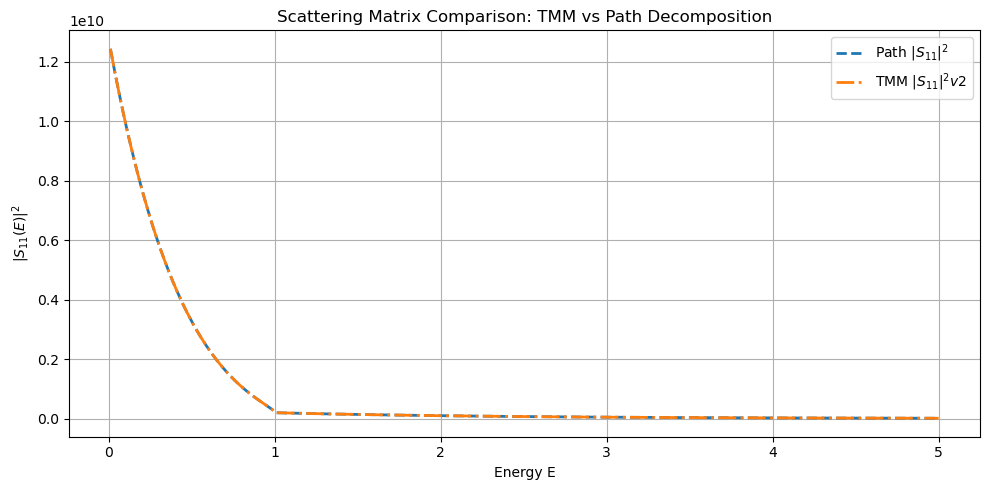

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(E_list, np.abs(S11_path_vals)**2, '--', label='Path $|S_{11}|^2$', linewidth=2)
plt.plot(E_list, np.abs(S11_vals)**2, '-.', label='TMM $|S_{11}|^2 v2$', linewidth=2)
plt.xlabel('Energy E')
plt.ylabel(r'$|S_{11}(E)|^2$')
plt.title('Scattering Matrix Comparison: TMM vs Path Decomposition')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

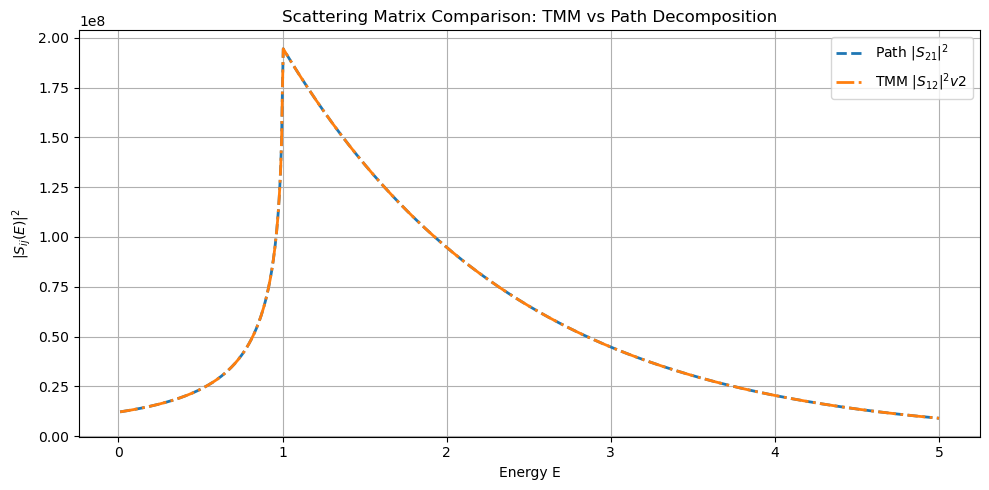

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(E_list, np.abs(S12_path_vals)**2, '--', label='Path $|S_{21}|^2$', linewidth=2)
plt.plot(E_list, np.abs(S12_vals)**2, '-.', label='TMM $|S_{12}|^2 v2$', linewidth=2)
plt.xlabel('Energy E')
plt.ylabel(r'$|S_{ij}(E)|^2$')
plt.title('Scattering Matrix Comparison: TMM vs Path Decomposition')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

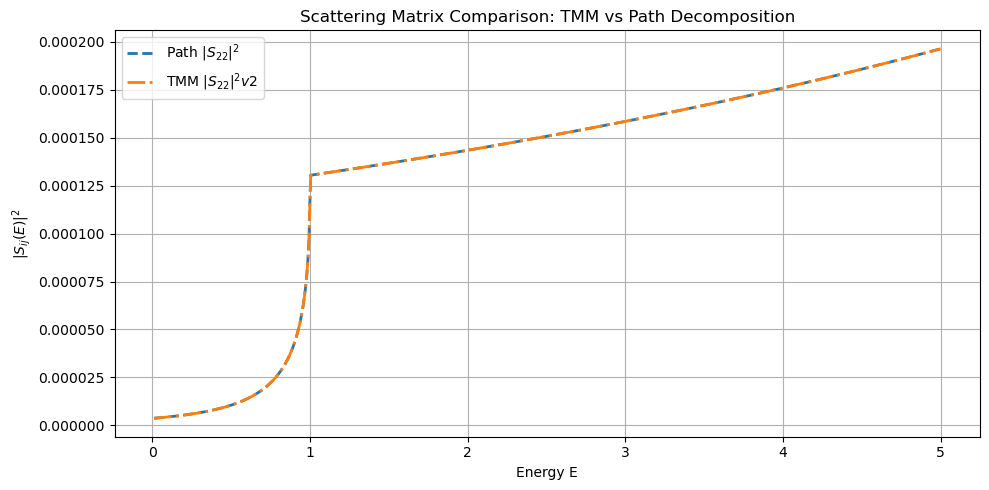

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(E_list, np.abs(S22_path_vals)**2, '--', label='Path $|S_{22}|^2$', linewidth=2)
plt.plot(E_list, np.abs(S22_vals)**2, '-.', label='TMM $|S_{22}|^2 v2$', linewidth=2)
plt.xlabel('Energy E')
plt.ylabel(r'$|S_{ij}(E)|^2$')
plt.title('Scattering Matrix Comparison: TMM vs Path Decomposition')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

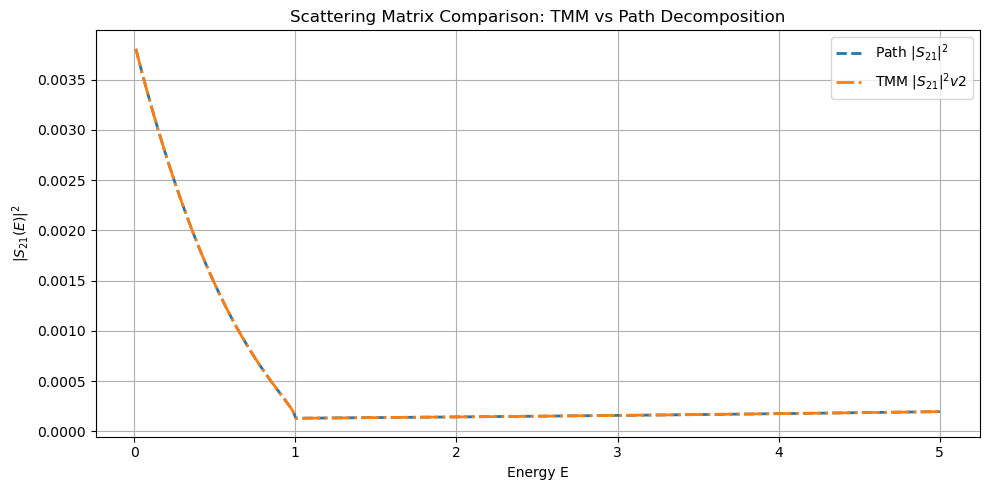

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(E_list, np.abs(S21_path_vals)**2, '--', label='Path $|S_{21}|^2$', linewidth=2)
plt.plot(E_list, np.abs(S21_vals)**2, '-.', label='TMM $|S_{21}|^2 v2$', linewidth=2)
plt.xlabel('Energy E')
plt.ylabel(r'$|S_{21}(E)|^2$')
plt.title('Scattering Matrix Comparison: TMM vs Path Decomposition')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()